In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import time
from ipypb import track

import WRCP_ALS3 as wrcp
from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor
from general_functions import create_filter, hr

### Zero launch of a function(for NUMBA):

In [3]:
init_shape = (100, 100, 10)
coo, vals = gen_coo_tensor(init_shape, density=0.002)
assert check_coo_tensor(coo)!= "Bad"

In [5]:
%%time

max_iter = 12
rank = 5
seed = 13

a, b, c, _, _ = wrcp.wrcp_als3(
    coo, vals, init_shape,
    rank=rank,
    l2=0.25,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)

rerr = sqrt_err_relative(
    coo, vals, init_shape, a, b, c,
)

print(rerr)

0.34359292885977255
CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 10.1 ms


### Load the data:

In [6]:
path_data = "Link_Prediction_Data/FB15K237/"
entity_list = pickle.load(open(path_data + 'entity_list', 'rb'))
relation_list = pickle.load(open(path_data + 'relation_list', 'rb'))

train_triples = pickle.load(open(path_data + 'train_triples', 'rb'))
valid_triples = pickle.load(open(path_data + 'valid_triples', 'rb'))
test_triples = pickle.load(open(path_data + 'test_triples', 'rb'))
train_valid_triples = pickle.load(open(path_data + 'train_valid_triples', 'rb'))

entity_map = pickle.load(open(path_data + 'entity_map', 'rb'))
relation_map = pickle.load(open(path_data + 'relation_map', 'rb'))

all_triples = train_valid_triples + test_triples

In [6]:
print(entity_list[:3], "\n", len(entity_list))

['/m/010016', '/m/0100mt', '/m/0102t4'] 
 14541


In [7]:
print(relation_list[:3], "\n", len(relation_list))

['/american_football/football_team/current_roster./sports/sports_team_roster/position', '/award/award_category/category_of', '/award/award_category/disciplines_or_subjects'] 
 237


In [8]:
len(train_triples)

272115

In [9]:
len(valid_triples)

17535

In [10]:
len(test_triples)

20466

In [11]:
len(train_valid_triples)

289650

In [12]:
len(all_triples)

310116

In [13]:
list(entity_map.items())[:2]

[('/m/010016', 0), ('/m/0100mt', 1)]

In [14]:
list(relation_map.items())[:2]

[('/american_football/football_team/current_roster./sports/sports_team_roster/position',
  0),
 ('/award/award_category/category_of', 1)]

In [7]:
test_filter = create_filter(test_triples, all_triples)  
valid_filter = create_filter(valid_triples, all_triples)  

### Create Sparse COO Train Tensor:

In [8]:
values = [1] * len(train_triples)
values = np.array(values, dtype=np.float64)

coords = np.array(train_triples, dtype=np.int32)
nnz = len(train_triples)
data_shape = (len(entity_list), len(relation_list), len(entity_list))
data_shape

(14541, 237, 14541)

## WRCP-ALS3:

In [119]:
max_iter = 4
rank = 200
l2 = 4e0
seed = 13

In [120]:
%%time
a, b, c, err_arr, it = wrcp.wrcp_als3(
    coords, values, data_shape,
    rank=rank,
    l2=l2,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)

CPU times: user 29min 17s, sys: 46.7 s, total: 30min 4s
Wall time: 17min 59s


In [121]:
rerr = sqrt_err_relative(
    coords, values, data_shape, a, b, c,
)
print(f"Relative error = {rerr}")

Relative error = 0.2520450030424172


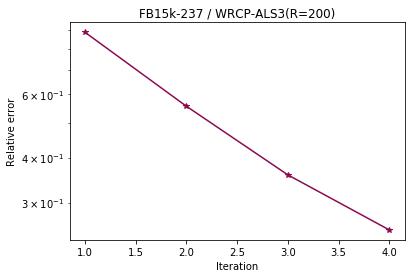

In [122]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"FB15k-237 / WRCP-ALS3(R={rank})")
#plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(1, it+1), err_arr[:it], '-*', c="#8b0a50")

In [123]:
%%time
hr(valid_filter, valid_triples, a, b, c, [1, 3, 10])

CPU times: user 2min 57s, sys: 82.1 ms, total: 2min 57s
Wall time: 2min 57s


(0.15186769318505847,
 0.2512118619903051,
 0.37610493299116055,
 0.22715337064941524)

In [124]:
%%time
hr(test_filter, test_triples, a, b, c, [1, 3, 10])

CPU times: user 3min 30s, sys: 110 ms, total: 3min 30s
Wall time: 3min 30s


(0.14697547151373008,
 0.2457734779634516,
 0.3702726473175022,
 0.22171678978882012)

## Find best parameters:

In [21]:
ranks = (25, 50, 100, 200, 300, 400, 600, 700)
l2 = 3e0
n_iter = 2
seed = 13

In [22]:
table_results = pd.DataFrame(
    np.zeros((len(ranks), 14)),
    index=[i for i in range(1, len(ranks) + 1)],
    columns=("iter", "rank", "l2", "time_train",
             "time_hr", "error", "hr1_valid", "hr1_test",
             "hr3_valid", "hr3_test", "hr10_valid", "hr10_test", 
             "mrr_valid", "mrr_test"),
)
table_results

,iter,rank,l2,time_train,time_hr,error,hr1_valid,hr1_test,hr3_valid,hr3_test,hr10_valid,hr10_test,mrr_valid,mrr_test
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
idx = 0
for rank in track(ranks):
    idx += 1
    # Train model
    start_tr = time.time()
    a, b, c, err_arr, it = wrcp.wrcp_als3(
        coords, values, data_shape,
        rank=rank,
        l2=l2,
        max_iter=n_iter,
        seed=seed,
        show_iter=False,
        it_over=False,
    )
    end_tr = time.time()
            
    # Find relative error
    rerr = sqrt_err_relative(
        coords, values, data_shape, a, b, c,
    )
    
    # Find Hit Rate on a validation set
    start_hr = time.time()
    hr1_valid, hr3_valid, hr10_valid, mrr_valid = hr(
        valid_filter, valid_triples, a, b, c, [1, 3, 10]
    )
    
    # Find Hit Rate on a test set
    hr1_test, hr3_test, hr10_test, mrr_test = hr(
        test_filter, test_triples, a, b, c, [1, 3, 10]
    )
    end_hr = time.time()
            
    table_results.loc[idx]["iter"] = n_iter
    table_results.loc[idx]["rank"] = rank
    table_results.loc[idx]["l2"] = l2
    table_results.loc[idx]["time_train"] = end_tr - start_tr
    table_results.loc[idx]["time_hr"] = end_hr - start_hr
    table_results.loc[idx]["error"] = rerr
    
    table_results.loc[idx]["hr1_valid"] = hr1_valid
    table_results.loc[idx]["hr1_test"] = hr1_test
    
    table_results.loc[idx]["hr3_valid"] = hr3_valid
    table_results.loc[idx]["hr3_test"] = hr3_test
    
    table_results.loc[idx]["hr10_valid"] = hr10_valid
    table_results.loc[idx]["hr10_test"] = hr10_test
    
    table_results.loc[idx]["mrr_valid"] = mrr_valid
    table_results.loc[idx]["mrr_test"] = mrr_test 

 [████████████████████████████████████████████████████████████] 8/8 [06:58:19<02:53:24, 3137.36s/it]

In [25]:
table_results

,iter,rank,l2,time_train,time_hr,error,hr1_valid,hr1_test,hr3_valid,hr3_test,hr10_valid,hr10_test,mrr_valid,mrr_test
1,2.0,25.0,3.0,57.915908,173.991792,0.504821,0.087254,0.085068,0.170003,0.169501,0.284745,0.282175,0.151616,0.150058
2,2.0,50.0,3.0,77.459595,187.904727,0.467976,0.108412,0.109694,0.174109,0.171553,0.278586,0.272061,0.165335,0.164182
3,2.0,100.0,3.0,170.230220,245.698953,0.454250,0.121300,0.118734,0.209866,0.203606,0.335443,0.330304,0.191870,0.187841
4,2.0,200.0,3.0,601.279681,372.757279,0.448548,0.143370,0.141992,0.248760,0.246555,0.399544,0.397000,0.226974,0.225227
5,2.0,300.0,3.0,1388.557713,622.985583,0.440729,0.166182,0.162904,0.266724,0.260188,0.406159,0.403205,0.245227,0.241069
6,2.0,400.0,3.0,2581.152166,756.841233,0.448364,0.185572,0.176732,0.296436,0.287648,0.446136,0.439949,0.270000,0.262232
7,2.0,600.0,3.0,6361.325325,1095.169471,0.436204,0.151069,0.147904,0.258112,0.252907,0.393670,0.386886,0.233253,0.228886
8,2.0,700.0,3.0,9149.126648,1254.202000,0.438820,0.197434,0.191146,0.314172,0.304016,0.449672,0.445959,0.282388,0.275306


In [27]:
table_results.to_csv("Link_Prediction_Factors/FB15K237/results.csv")

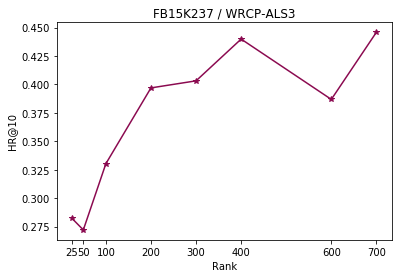

In [29]:
plt.xlabel("Rank")
plt.ylabel("HR@10")
plt.title(f"FB15K237 / WRCP-ALS3")
plt.xticks(table_results['rank'])
#plt.yscale("log")
plt.plot(table_results['rank'], table_results['hr10_test'], '-*', c="#8b0a50")

## Merge train and valid sets:

In [42]:
tv_values = [1] * len(train_valid_triples)
tv_values = np.array(tv_values, dtype=np.float64)

tv_coords = np.array(train_valid_triples, dtype=np.int32)
nnz = len(train_valid_triples)
data_shape = (len(entity_list), len(relation_list), len(entity_list))
data_shape

(14206, 235, 14206)

In [43]:
max_iter = 2
rank = 700
l2 = 3e0
seed = 13

In [44]:
%%time
a, b, c, err_arr, it = wrcp.wrcp_als3(
    coords, values, data_shape,
    rank=rank,
    l2=l2,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)

CPU times: user 3h 36min 47s, sys: 3min 59s, total: 3h 40min 47s
Wall time: 2h 44min 50s


In [45]:
%%time
hr(test_filter, test_triples, a, b, c, [1, 3, 10])

CPU times: user 46min 58s, sys: 8min 57s, total: 55min 56s
Wall time: 55min 45s


(0.4224198573007738, 8407, 19902)

### Save Factors:

In [47]:
path_factors = "Link_Prediction_Factors/FB15K237/"

pickle.dump(a, open(path_factors + 'A_factor', 'wb'))
pickle.dump(b, open(path_factors + 'B_factor', 'wb'))
pickle.dump(c, open(path_factors + 'C_factor', 'wb'))
pickle.dump(err_arr, open(path_factors + 'Errors', 'wb'))

## We can load calculated factors:

In [ ]:
path_factors = "Link_Prediction_Factors/FB15K237/"

a = pickle.load(open(path_factors + 'A_factor', 'rb'))
b = pickle.load(open(path_factors + 'B_factor', 'rb'))
c = pickle.load(open(path_factors + 'C_factor', 'rb'))

In [ ]:
%%time
hr(valid_filter, valid_triples, a, b, c, [1, 3, 10])

In [ ]:
%%time
hr(test_filter, test_triples, a, b, c, [1, 3, 10])

## Let's look at Tucker TD:

In [45]:
import polara.lib.hosvd as hosvd

In [66]:
%%time
core_shape = (50, 50, 50)
p, q, r, g = hosvd.tucker_als(
    idx=coords,
    val=values,
    shape=data_shape,
    core_shape=core_shape,
    iters=100,
    growth_tol=0.01,
    batch_run=False,
    seed=15,
)

Step 1 of 100
growth of the core: 1.000000
Step 2 of 100
growth of the core: 0.071140
Step 3 of 100
growth of the core: 0.004568
Core is no longer growing. Norm of the core: 264.036868
Done
CPU times: user 57.5 s, sys: 1.46 s, total: 59 s
Wall time: 32.9 s


In [47]:
from numba import jit

@jit(nopython=True) 
def sqrt_err_tucker(coo_tensor, vals, shape, a, b, c, g):
    result = 0.0
    for item in range(coo_tensor.shape[0]):
        coord = coo_tensor[item]
        elem = 0.0
        for p in range(a.shape[1]):
            for q in range(b.shape[1]):
                for r in range(c.shape[1]):
                    elem += g[p, q, r] * a[coord[0], p] * b[coord[1], q] * c[coord[2], r]
        
        result += (vals[item] - elem)**2  
    return np.sqrt(result)

@jit(nopython=True) 
def sqrt_err_relative_tucker(coo_tensor, vals, shape, a, b, c, g):
    result = sqrt_err_tucker(coo_tensor, vals, shape, a, b, c, g)        
    return result / np.sqrt((vals**2).sum())

In [48]:
rerr = sqrt_err_relative_tucker(
    coords,
    values,
    data_shape,
    p,
    q,
    r,
    g,
)
print(f"Relative error = {rerr}")

Relative error = 0.8359549117941131


In [89]:
@jit(nopython=True)
def hit_rate_tucker_raw(test_triples, a, b, c, g,
             how_many=10, iter_show=False, freq=3000):
    
    total = len(test_triples)
    hit = 0
    iteration = 0
    for entity in test_triples:
        iteration += 1
        p = entity[0]
        q = entity[1]
        r = entity[2]
        
        candidate_values = np.sum(g[p, q, :] * a[p, :] * b[q, :] * c, axis=1)
        candidate_values = sigmoid(candidate_values)
        
        top = np.argsort(candidate_values)[::-1][:how_many]
        
        for x in top:
            if x == r:
                hit += 1
                
        if iter_show:
            if iteration % freq == 0:
                print(hit / iteration, hit, iteration)
            
    return hit / total, hit, total

hit_rate_tucker_raw(
    test_triples[:5],
    p, q, r, g, 10,
    iter_show=False,
    freq=2,
)

(0.0, 0, 5)

In [ ]:
hit_rate_tucker_raw(
    test_triples,
    p, q, r, g, 10,
    iter_show=True,
    freq=1000,
)

0.017 17 1000
0.0125 25 2000
0.010333333333333333 31 3000
0.01 40 4000
0.0108 54 5000
0.011